In [1]:
import sys
sys.path.extend(['/home/quic/QUIC-Projects'])

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
DATA_DIR = Path('/home/quic/QUIC-Projects/summary_ipynb/2021/10 October/15 Fri/Exp2(trs=64)')
OBJ_FUNC = r'$\mathcal{K}_{k, \lambda}^{\mathcal{S}}$'

In [2]:
from pandas import read_csv, DataFrame
data = read_csv(DATA_DIR/'Samples/sample_summary.csv')

def clean_pivot(df, agg_func='mean'):
    temp = df.pivot_table(values=list(df.columns[4:]), index=list(df.columns[0:4]), aggfunc=agg_func)
    return DataFrame(columns=list(temp.index.names)+list(temp.columns), data=np.hstack([np.asarray(list(temp.index)), temp.to_numpy()]))
for m in ['mean', 'median', 'std', 'min', 'max']:
    clean_pivot(data, m).to_csv(DATA_DIR / f'summary({m}).csv', index=False)


X = np.load(DATA_DIR/'DataSets/X.npy')
Xt = np.load(DATA_DIR/'DataSets/Xt.npy')
y = np.load(DATA_DIR/'DataSets/y.npy')
yt = np.load(DATA_DIR/'DataSets/yt.npy')

In [3]:
from itertools import product
min_select_result = DataFrame(columns=data.columns)
for cid, ly in product(range(1, 20), range(1, 9)):
    min_val = min(data.loc[(data['circuit_id']==cid) & (data['layer']==ly)]['last_cost_avg'])
    data_df = data.loc[(data['circuit_id']==cid) & (data['layer']==ly)]
    min_select_result = min_select_result.append(data_df.loc[data_df['last_cost_avg']==min_val], ignore_index=True)
    
min_select_result.loc[min_select_result['circuit_id']==15]
    

,dataset,circuit_id,layer,num_params,expr,entcap,num_iter,last_cost_avg,accuracy
112,0,15,1,6,0.567396,0.677565,42,0.114346,0.921875
113,0,15,2,12,0.189553,0.744091,49,0.113266,0.937500
114,0,15,3,18,0.090994,0.874990,140,0.078434,0.968750
115,0,15,4,24,0.045076,0.894793,107,0.083107,0.953125
116,0,15,5,30,0.077400,0.922199,181,0.068390,0.921875
117,0,15,6,36,0.067235,0.925718,85,0.096779,0.875000
118,0,15,7,42,0.051004,0.935232,132,0.090435,0.953125
119,0,15,8,48,0.070495,0.936841,79,0.086998,0.890625


In [4]:
data.loc[(data['circuit_id']==15) & (data['layer']==3)]

,dataset,circuit_id,layer,num_params,expr,entcap,num_iter,last_cost_avg,accuracy
912,0,15,3,18,0.076898,0.873254,109,0.121059,0.937500
913,0,15,3,18,0.087281,0.877664,83,0.081848,0.921875
914,0,15,3,18,0.090994,0.874990,140,0.078434,0.968750
915,0,15,3,18,0.092984,0.870342,82,0.147655,0.906250
916,0,15,3,18,0.092862,0.870824,100,0.103001,0.937500
917,0,15,3,18,0.098910,0.870048,91,0.115814,0.937500
918,0,15,3,18,0.104322,0.873683,54,0.131721,0.953125
919,0,15,3,18,0.073533,0.877178,41,0.117699,0.875000


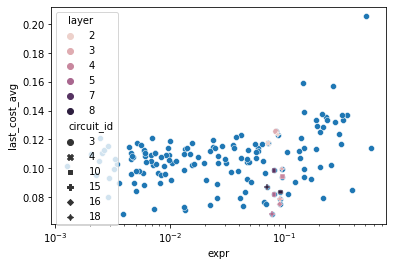

In [5]:
%matplotlib inline
import seaborn as sns
sns.scatterplot(data=min_select_result, x='expr', y='last_cost_avg')
sns.scatterplot(data=min_select_result.loc[(min_select_result['expr']>0.07) & (min_select_result['expr']<0.1) & (min_select_result['last_cost_avg']<1)], x='expr', y='last_cost_avg', hue='layer', style='circuit_id')
plt.xscale('log')

In [6]:
# mask = (svm.predict(Xt)==yt)
# data.loc[(data['circuit_id']==15) & (data['layer']==4)]    
import json
# with open(DATA_DIR / 'Samples/Circuit #15/layer=5/1/full_result.json', 'r') as f:
with open(DATA_DIR / '(15, 5)-1024/full_result.json', 'r') as f:
    f_vector = json.load(f)['f']
mask = (f_vector * (2*yt-1) > 0)

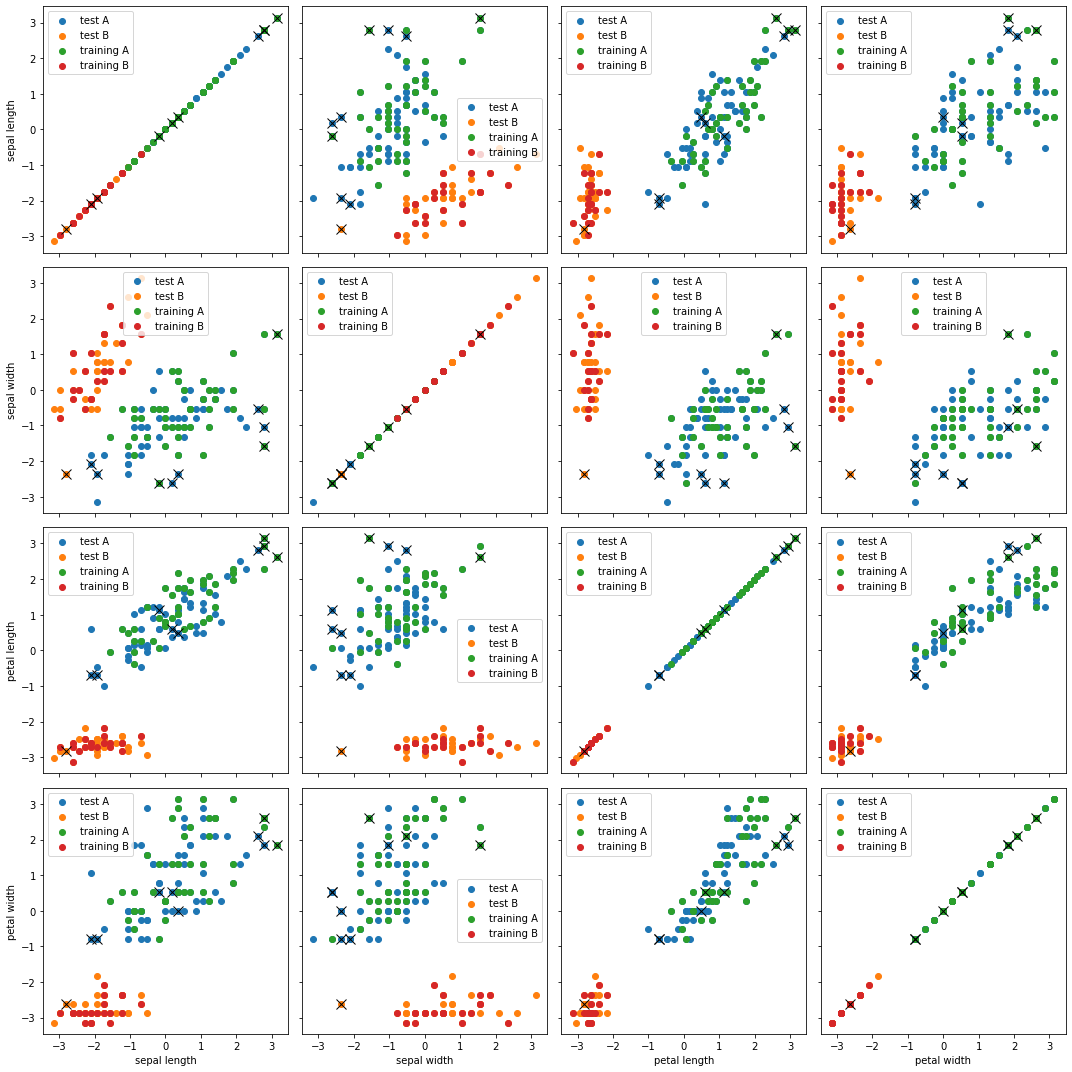

In [7]:
%matplotlib inline
from sklearn.datasets import load_iris
ds = load_iris()



fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, squeeze=True, figsize=(15, 15))
from itertools import product
for e1, e2 in product(range(4), repeat=2):
    ax = axes[e2, e1]
    ax.scatter(Xt[yt==0, e1], Xt[yt==0, e2], label='test A')
    ax.scatter(Xt[yt==1, e1], Xt[yt==1, e2], label='test B')

    ax.scatter(X[y==0, e1], X[y==0, e2], label='training A')
    ax.scatter(X[y==1, e1], X[y==1, e2], label='training B')

    ax.plot(Xt[~mask, e1], Xt[~mask, e2], marker='x', mec='k', mfc='none', markersize=10, linestyle='none')

    ax.legend()
    if e2==3:
        ax.set_xlabel(ds.feature_names[e1].split(' (cm)')[0])
    if e1==0:
        ax.set_ylabel(ds.feature_names[e2].split(' (cm)')[0])
plt.tight_layout()
plt.savefig('./figs/si_iris_dataset.png', dpi=200)

In [8]:
"""
import dill
from tqdm.notebook import tqdm
# with open(DATA_DIR / 'Samples/Circuit #15/layer=4/4/nqsvm', 'rb') as f:
with open(DATA_DIR / 'Samples/Circuit #15/layer=5/1/nqsvm', 'rb') as f:
    qasvm = dill.load(f)
    
_init = qasvm.parameters.copy()
_init.update(qasvm.initial_point)
var_qc = qasvm.var_form.assign_parameters(dict(zip(qasvm.var_form.parameters, _init)))
var_qc.save_statevector()
result = qasvm.quantum_instance.execute(var_qc)
initial_point = np.abs(result.get_statevector()) ** 2

from copy import deepcopy
from classifiers.quantum.qasvm import PseudoNormQSVM
from classifiers.optimizer import tSPSA
from classifiers.callback import CostParamStorage
feature_map = deepcopy(qasvm.feature_map)

pqasvm = PseudoNormQSVM(data=qasvm.data, label=qasvm.label, quantum_instance=qasvm.quantum_instance, lamda=qasvm.lamda, feature_map=feature_map, var_form=None, initial_point=initial_point)

storage = CostParamStorage()
optimizer = tSPSA(maxiter=2**15, blocking=True, last_avg=16, callback=storage)
for epoch in tqdm(range(1, 2**15 + 1)):
    optimizer.step(pqasvm.cost_fn, pqasvm.parameters)
    if storage.num_accepted() > 2 * 16 and storage.last_cost_avg(2 * 16, ignore_rejected=True) < \
            storage.last_cost_avg(16, ignore_rejected=True):
        break
pqasvm.parameters = storage.last_avg(16, ignore_rejected=True)
last_cost = storage.last_cost_avg(16, ignore_rejected=True)
"""

"\nimport dill\nfrom tqdm.notebook import tqdm\n# with open(DATA_DIR / 'Samples/Circuit #15/layer=4/4/nqsvm', 'rb') as f:\nwith open(DATA_DIR / 'Samples/Circuit #15/layer=5/1/nqsvm', 'rb') as f:\n    qasvm = dill.load(f)\n    \n_init = qasvm.parameters.copy()\n_init.update(qasvm.initial_point)\nvar_qc = qasvm.var_form.assign_parameters(dict(zip(qasvm.var_form.parameters, _init)))\nvar_qc.save_statevector()\nresult = qasvm.quantum_instance.execute(var_qc)\ninitial_point = np.abs(result.get_statevector()) ** 2\n\nfrom copy import deepcopy\nfrom classifiers.quantum.qasvm import PseudoNormQSVM\nfrom classifiers.optimizer import tSPSA\nfrom classifiers.callback import CostParamStorage\nfeature_map = deepcopy(qasvm.feature_map)\n\npqasvm = PseudoNormQSVM(data=qasvm.data, label=qasvm.label, quantum_instance=qasvm.quantum_instance, lamda=qasvm.lamda, feature_map=feature_map, var_form=None, initial_point=initial_point)\n\nstorage = CostParamStorage()\noptimizer = tSPSA(maxiter=2**15, blocking=T

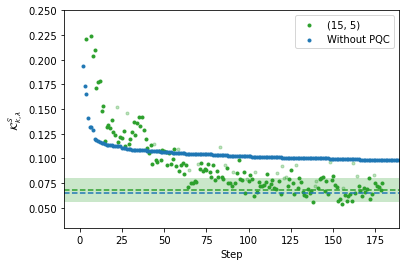

In [9]:
%matplotlib inline

"""
_tmp_path = DATA_DIR / 'Classical'
_tmp_path.mkdir(exist_ok=True)
pqasvm.save(_tmp_path / 'qasvm')
storage.save(_tmp_path / 'storage')
"""
import dill
with open(DATA_DIR / 'Classical' / 'storage', 'rb') as f:
#with open(DATA_DIR / 'Classical' / 'storage_blocking', 'rb') as f:
    storage = dill.load(f)
with open(DATA_DIR / 'Classical' / 'qasvm', 'rb') as f:
#with open(DATA_DIR / 'Classical' / 'qasvm_blocking', 'rb') as f:
    pqasvm = dill.load(f)
last_cost = storage.last_cost_avg(16, ignore_rejected=True)


# with open(DATA_DIR / 'Samples/Circuit #15/layer=4/4/storage', 'rb') as f:
with open(DATA_DIR / 'Samples/Circuit #15/layer=5/1/storage', 'rb') as f:
# with open(DATA_DIR / '(15, 5)-1024/storage', 'rb') as f:
    qasvm_storage = dill.load(f)
    
color2, _, color1 = '#1f77b4', '#ff7f0e', '#2ca02c'
# df1 = storage.data.iloc[:len(qasvm_storage.data)]
df1 = qasvm_storage.data
df2 = storage.data
plt.scatter(df1.loc[df1['Accepted']==True]['Step'], df1.loc[df1['Accepted']==True]['Cost'], marker='.', c=color1, label='(15, 5)')
#plt.scatter(range(len(df1.loc[df1['Accepted']==True])), df1.loc[df1['Accepted']==True]['Cost'], marker='.', c=color1, label='QASVM')
plt.scatter(df1.loc[df1['Accepted']==False]['Step'], df1.loc[df1['Accepted']==False]['Cost'], marker='.', alpha=0.3, c=color1)
plt.scatter(df2.loc[df2['Accepted']==True]['Step'], df2.loc[df2['Accepted']==True]['Cost'], marker='.', c=color2, label='Without PQC')
#plt.scatter(range(len(df2.loc[df2['Accepted']==True])), df2.loc[df2['Accepted']==True]['Cost'], marker='.', c=color2, label='Without PQC')
plt.scatter(df2.loc[df2['Accepted']==False]['Step'], df2.loc[df2['Accepted']==False]['Cost'], marker='.', alpha=0.3, c=color2)
plt.axhline(last_cost, 0, 1, color=color2, linestyle='--')
plt.axhline(qasvm_storage.last_cost_avg(16, ignore_rejected=True), 0, 1, color=color1, linestyle='--')
plt.axhspan(ymin=qasvm_storage.last_cost_avg(16, ignore_rejected=True)-2*qasvm_storage.last_cost_std(16, ignore_rejected=True),
            ymax=qasvm_storage.last_cost_avg(16, ignore_rejected=True)+2*qasvm_storage.last_cost_std(16, ignore_rejected=True),
            xmin=0, xmax=1, facecolor=color1, alpha=0.25)
plt.ylim([None, 0.25])
plt.xlim([-len(df1)*.05, len(df1)*1.05])
plt.xlabel('Step')
plt.ylabel(OBJ_FUNC)
plt.legend(loc='upper right')
plt.savefig('./figs/si_spsa_progress.png', dpi=200)
plt.show()

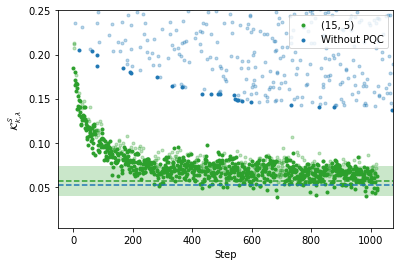

In [10]:
%matplotlib inline

"""
_tmp_path = DATA_DIR / 'Classical'
_tmp_path.mkdir(exist_ok=True)
pqasvm.save(_tmp_path / 'qasvm')
storage.save(_tmp_path / 'storage')
"""
import dill
#with open(DATA_DIR / 'Classical' / 'storage', 'rb') as f:
with open(DATA_DIR / 'Classical' / 'storage_blocking', 'rb') as f:
    storage = dill.load(f)
#with open(DATA_DIR / 'Classical' / 'qasvm', 'rb') as f:
with open(DATA_DIR / 'Classical' / 'qasvm_blocking', 'rb') as f:
    pqasvm = dill.load(f)
last_cost = storage.last_cost_avg(16, ignore_rejected=True)


# with open(DATA_DIR / 'Samples/Circuit #15/layer=4/4/storage', 'rb') as f:
#with open(DATA_DIR / 'Samples/Circuit #15/layer=5/1/storage', 'rb') as f:
with open(DATA_DIR / '(15, 5)-1024/storage', 'rb') as f:
    qasvm_storage = dill.load(f)
    
color2, _, color1 = '#1f77b4', '#ff7f0e', '#2ca02c'
# df1 = storage.data.iloc[:len(qasvm_storage.data)]
df1 = qasvm_storage.data
df2 = storage.data
plt.scatter(df1.loc[df1['Accepted']==True]['Step'], df1.loc[df1['Accepted']==True]['Cost'], marker='.', c=color1, label='(15, 5)')
#plt.scatter(range(len(df1.loc[df1['Accepted']==True])), df1.loc[df1['Accepted']==True]['Cost'], marker='.', c=color1, label='QASVM')
plt.scatter(df1.loc[df1['Accepted']==False]['Step'], df1.loc[df1['Accepted']==False]['Cost'], marker='.', alpha=0.3, c=color1)
plt.scatter(df2.loc[df2['Accepted']==True]['Step'], df2.loc[df2['Accepted']==True]['Cost'], marker='.', c=color2, label='Without PQC')
#plt.scatter(range(len(df2.loc[df2['Accepted']==True])), df2.loc[df2['Accepted']==True]['Cost'], marker='.', c=color2, label='Without PQC')
plt.scatter(df2.loc[df2['Accepted']==False]['Step'], df2.loc[df2['Accepted']==False]['Cost'], marker='.', alpha=0.3, c=color2)
plt.axhline(last_cost, 0, 1, color=color2, linestyle='--')
plt.axhline(qasvm_storage.last_cost_avg(16, ignore_rejected=True), 0, 1, color=color1, linestyle='--')
plt.axhspan(ymin=qasvm_storage.last_cost_avg(16, ignore_rejected=True)-2*qasvm_storage.last_cost_std(16, ignore_rejected=True),
            ymax=qasvm_storage.last_cost_avg(16, ignore_rejected=True)+2*qasvm_storage.last_cost_std(16, ignore_rejected=True),
            xmin=0, xmax=1, facecolor=color1, alpha=0.25)
plt.ylim([None, 0.25])
plt.xlim([-len(df1)*.05, len(df1)*1.05])
plt.xlabel('Step')
plt.ylabel(OBJ_FUNC)
plt.legend(loc='upper right')
plt.savefig('./figs/spsa_progress_blocking.png', dpi=200)
plt.show()

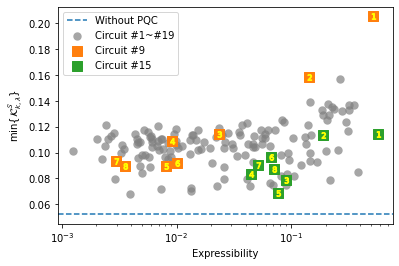

In [11]:
%matplotlib inline
c1, c2, c3 = '#1f77b4', '#ff7f0e', '#2ca02c'
cid=9
not15 = min_select_result.loc[min_select_result['circuit_id']!=cid]
yes15 = min_select_result.loc[min_select_result['circuit_id']==cid]
plt.scatter(not15['expr'], not15['last_cost_avg'], marker='o', color='grey', alpha=0.7, s=70, linewidth=0, label='Circuit #1~#19')#yerr=std_result['num_iter'])
plt.scatter(yes15['expr'], yes15['last_cost_avg'], marker='s', color=c2, s=100, label=f'Circuit #{cid}')
for l in range(1, 9):
    plt.scatter(yes15.loc[yes15['layer']==l]['expr'], yes15.loc[yes15['layer']==l]['last_cost_avg'], marker=f'${l}$', color='yellow')#yerr=std_result['num_iter'])
cid=15
not15 = min_select_result.loc[min_select_result['circuit_id']!=cid]
yes15 = min_select_result.loc[min_select_result['circuit_id']==cid]
plt.scatter(yes15['expr'], yes15['last_cost_avg'], marker='s', color=c3, s=100, label=f'Circuit #{cid}')
for l in range(1, 9):
    plt.scatter(yes15.loc[yes15['layer']==l]['expr'], yes15.loc[yes15['layer']==l]['last_cost_avg'], marker=f'${l}$', color='yellow')#yerr=std_result['num_iter'])
plt.axhline(y=last_cost, linestyle='--', label='Without PQC', color=c1)
plt.xscale('log')
plt.xlabel('Expressibility')
plt.ylabel('min{' + OBJ_FUNC + '}')
plt.legend()
plt.savefig('./figs/expr_vs_cost.png', dpi=200)
plt.show()

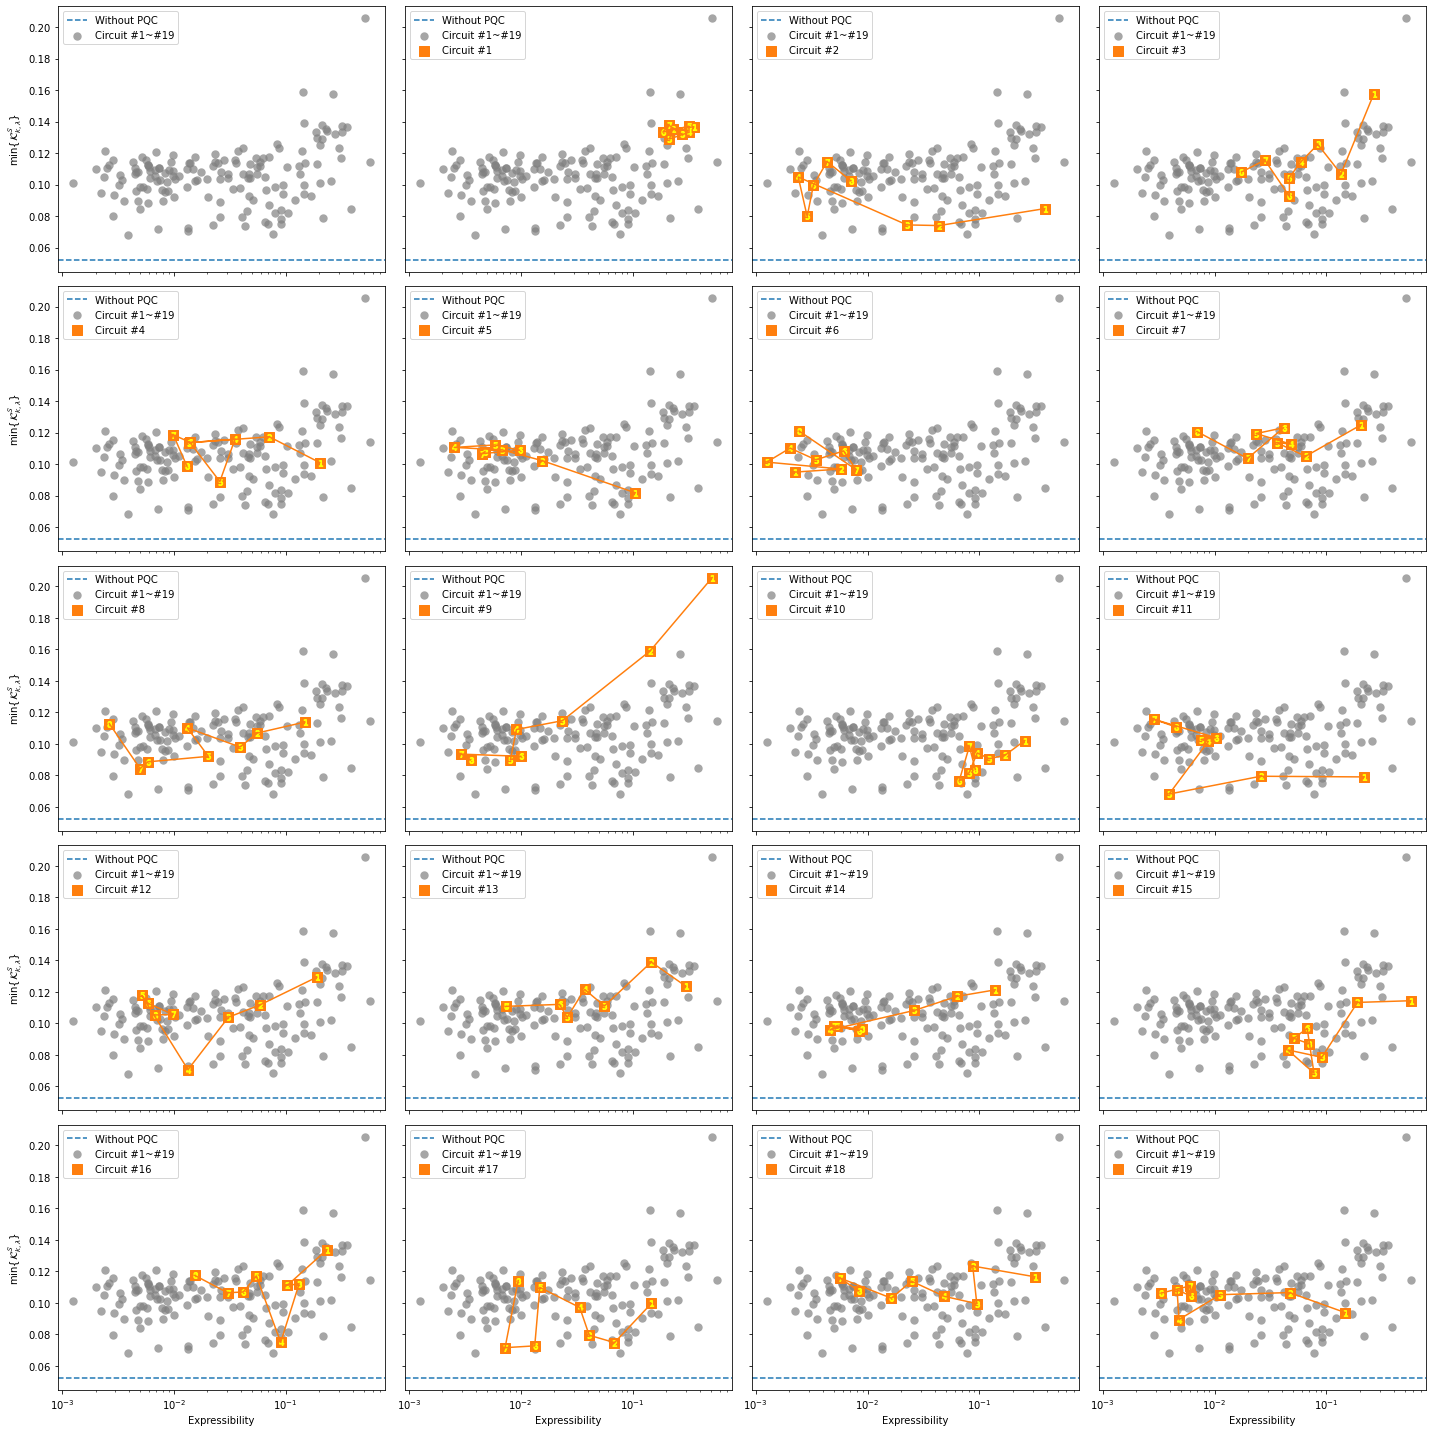

In [12]:
%matplotlib inline
c1, c2, c3 = '#1f77b4', '#ff7f0e', '#2ca02c'
fig, axes = plt.subplots(5, 4, figsize=(20, 20), squeeze=True, sharex=True, sharey=True)
for cid in list(range(1, 21)):
    ax = axes.flatten()[cid%20]
    not15 = min_select_result.loc[min_select_result['circuit_id']!=cid]
    yes15 = min_select_result.loc[min_select_result['circuit_id']==cid]
    ax.scatter(not15['expr'], not15['last_cost_avg'], marker='o', color='grey', alpha=0.7, s=70, linewidth=0, label='Circuit #1~#19')#yerr=std_result['num_iter'])
    ax.plot(yes15['expr'], yes15['last_cost_avg'], marker='', color=c2)
    if cid<20:
        ax.scatter(yes15['expr'], yes15['last_cost_avg'], marker='s', color=c2, s=100, label=f'Circuit #{cid}')
    for l in range(1, 9):
        ax.scatter(yes15.loc[yes15['layer']==l]['expr'], yes15.loc[yes15['layer']==l]['last_cost_avg'], marker=f'${l}$', color='yellow')#yerr=std_result['num_iter'])
    ax.axhline(y=last_cost, linestyle='--', label='Without PQC', color=c1)
    ax.set_xscale('log')
    if cid%20 in [0, 4, 8, 12, 16]:
        ax.set_ylabel('min{' + OBJ_FUNC + '}')
    if cid%20 in [16, 17, 18, 19]:
        ax.set_xlabel('Expressibility')
    ax.legend()
plt.tight_layout()
plt.savefig('./figs/si_expr_vs_cost.png', dpi=200)
plt.show()

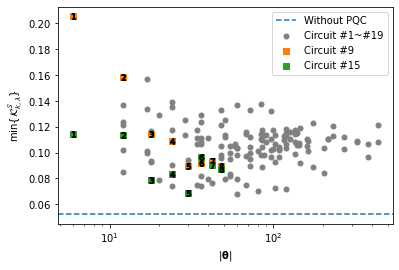

In [13]:
%matplotlib inline
c1, c2, c3 = '#1f77b4', '#ff7f0e', '#2ca02c'
cid=9
not15 = min_select_result.loc[min_select_result['circuit_id']!=cid]
yes15 = min_select_result.loc[min_select_result['circuit_id']==cid]
plt.scatter(not15['num_params'], not15['last_cost_avg'], marker='.', color='grey', s=100, label='Circuit #1~#19')#yerr=std_result['num_iter'])
plt.scatter(yes15['num_params'], yes15['last_cost_avg'], marker='s', color=c2, s=30, label=f'Circuit #{cid}')
for l in range(1, 9):
    plt.scatter(yes15.loc[yes15['layer']==l]['num_params'], yes15.loc[yes15['layer']==l]['last_cost_avg'], marker=f'${l}$', color='k')#yerr=std_result['num_iter'])
cid=15
not15 = min_select_result.loc[min_select_result['circuit_id']!=cid]
yes15 = min_select_result.loc[min_select_result['circuit_id']==cid]
plt.scatter(yes15['num_params'], yes15['last_cost_avg'], marker='s', color=c3, s=30, label=f'Circuit #{cid}')
for l in range(1, 9):
    plt.scatter(yes15.loc[yes15['layer']==l]['num_params'], yes15.loc[yes15['layer']==l]['last_cost_avg'], marker=f'${l}$', color='k')#yerr=std_result['num_iter'])
plt.axhline(y=last_cost, linestyle='--', label='Without PQC', color=c1)
plt.xscale('log')
plt.xlabel(r'$|\mathbf{\theta}|$')
plt.ylabel('min{' + OBJ_FUNC + '}')
plt.legend()
plt.show()

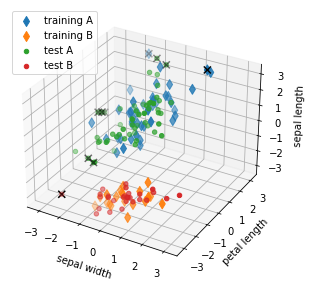

In [15]:

%matplotlib inline

test_mask = []
for j, xt in enumerate(Xt):
    test_mask.append(True)
    for x in X:
        if np.all(x==xt):
            test_mask[-1]=False
            break
            

fig = plt.figure(figsize=(5, 4))
ax = plt.axes(projection='3d')

e1, e2, e3 = 1, 2, 0


ax.scatter(X[y==0, e1], X[y==0, e2], X[y==0, e3], marker='d', label='training A', s=50)
ax.scatter(X[y==1, e1], X[y==1, e2], X[y==1, e3], marker='d', label='training B', s=50)

ax.scatter(Xt[test_mask][yt[test_mask]==0, e1], Xt[test_mask][yt[test_mask]==0, e2], Xt[test_mask][yt[test_mask]==0, e3], label='test A')
ax.scatter(Xt[test_mask][yt[test_mask]==1, e1], Xt[test_mask][yt[test_mask]==1, e2], Xt[test_mask][yt[test_mask]==1, e3], label='test B')

ax.scatter(Xt[~mask, e1], Xt[~mask, e2], Xt[~mask, e3], marker='x', color='k', s=50)

ax.legend()
ax.set_xlabel(ds.feature_names[e1].split(' (cm)')[0])
ax.set_ylabel(ds.feature_names[e2].split(' (cm)')[0])
ax.set_zlabel(ds.feature_names[e3].split(' (cm)')[0])
plt.tight_layout()
fig.savefig('./figs/iris_class.png', dpi=200)
plt.show()

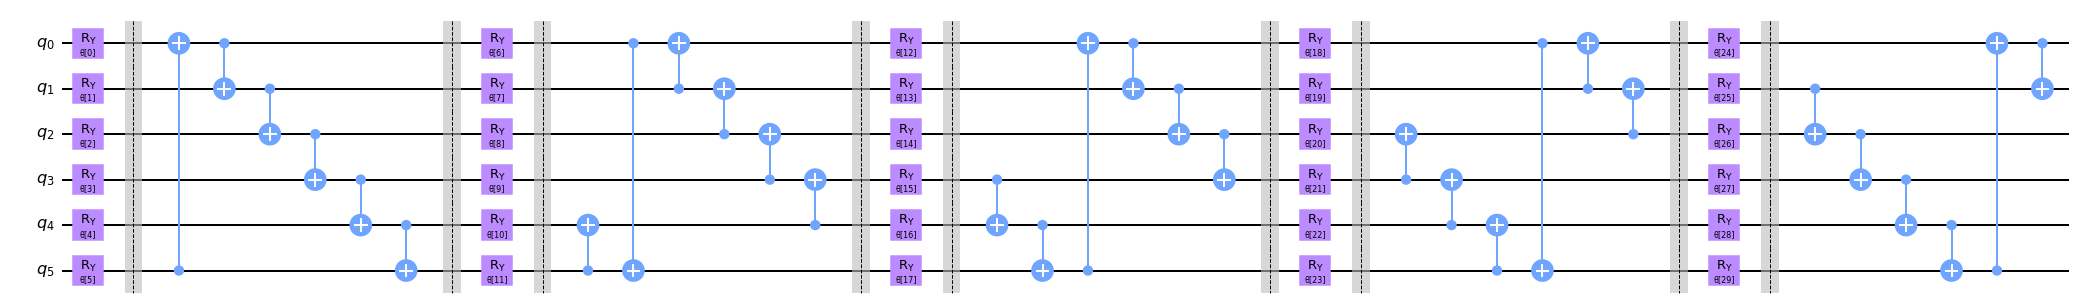

In [16]:
from classifiers.quantum.ansatz import Circuit15, Circuit16

fig = Circuit15(6, reps=5, insert_barriers=True).decompose().draw('mpl', fold=-1)
fig.savefig('./figs/circuit15.png')

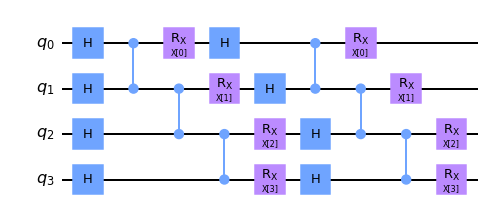

In [17]:
with open(DATA_DIR / '(15, 5)-1024/qasvm', 'rb') as f:
    qasvm = dill.load(f)
fig = qasvm.feature_map.decompose().draw('mpl', fold=-1)
fig.savefig('./figs/Cid19FeatureMap.png')

In [18]:
"""
from classifiers.convex.svm import BinarySVM
from qiskit_machine_learning.kernels import QuantumKernel

quantum_kernel = QuantumKernel(qasvm.feature_map, enforce_psd=False, quantum_instance=qasvm.quantum_instance)
def my_kernel(x, y):
    return (np.abs(quantum_kernel.evaluate([x], [y]))**2).item()
svm = BinarySVM(kernel=my_kernel, mutation='REDUCED_QASVM', k=qasvm.lamda, C=None)
svm.fit(qasvm.data, qasvm.label)
"""
import dill
import json

with open(DATA_DIR / 'Classical/svm', 'rb') as f:
    svm = dill.load(f)
    
with open(DATA_DIR / 'Classical/svm_result.json', 'r') as f:
    svm_acc = json.load(f)['accuracy']
    
with open(DATA_DIR / 'Classical/pqasvm_blocing_result.json', 'r') as f:
    pqasvm_acc = json.load(f)['accuracy']
    
    

In [21]:
svm_f = svm.f(Xt)
svm_cost = svm.result['dual objective']
svm_acc = sum(np.where(svm_f*(2*yt-1)>0, 1, 0))/len(yt)
pqasvm_f = pqasvm.f(Xt)
pqasvm_acc = sum(np.where(pqasvm_f*(2*yt-1)>0, 1, 0))/len(yt)
with open(DATA_DIR / '(15, 5)-1024/full_result.json', 'r') as f: 
    d = json.load(f)
    qasvm_f = d['f']
    qasvm_acc = d['accuracy']

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [50]:

print('\t svm\t pqasvm\t qasvm')
print('accuracy {:.2f}\t {:.2f}\t {:.2f}'.format(svm_acc, pqasvm_acc, qasvm_acc))
print('cost\t {:.2f}\t {:.2f}\t {:.2f}'.format(svm.result['dual objective'], last_cost, qasvm_storage.last_cost_avg(16, ignore_rejected=True)))
print('epochs\t {:}\t {:}\t {:}'.format(svm.result['iterations'], len(storage.data), len(qasvm_storage.data)))

	 svm	 pqasvm	 qasvm
accuracy 0.96	 0.93	 0.93
cost	 0.02	 0.05	 0.06
epochs	 10	 32767	 1023


In [30]:
svm.save(DATA_DIR / 'Classical/svm')
with open(DATA_DIR / 'Classical/svm_result.json', 'w') as f:
    json.dump(dict(f=list(svm_f), accuracy=svm_acc, last_cost=svm_cost), f)
with open(DATA_DIR / 'Classical/pqasvm_blocing_result.json', 'w') as f:
    json.dump(dict(f=list(pqasvm_f), accuracy=pqasvm_acc, last_cost=last_cost), f)